# Transformations and coordinate systems

In this notebook, we will describe some usage principles for *transformations* and *coordinate systems* in {class}`spatialdata.SpatialData`.

Let's first import some useful libraries and define a simple function to plot the data downstream.

In [1]:
import math

import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
import numpy as np
import scipy
from skimage.segmentation import slic
from spatialdata import SpatialData
from spatialdata._core._spatialdata_ops import get_transformation, set_transformation
from spatialdata._core.models import Image2DModel, Labels2DModel, ShapesModel
from spatialdata._core.transformations import (
    Affine,
    MapAxis,
    Scale,
    Sequence,
    Translation,
)


def plot_raccoon(sdata, split: bool = False, transform: bool = False):
    def plot_translation(transform_image, im_ax, ax):
        mpl_transform = mtransforms.Affine2D().translate(transform_image.translation[0], transform_image.translation[1])
        trans_data = mpl_transform + ax.transData
        im_ax.set_transform(trans_data)

        # display intended extent of the image
        x1, x2, y1, y2 = im_ax.get_extent()
        ax.plot([x1, x2, x2, x1, x1], [y1, y1, y2, y2, y1], "y--", transform=trans_data)

    image_elem = sdata.images["raccoon"]
    labels_elem = sdata.labels["segmentation"]
    shapes_elem = sdata.shapes["circles"]
    if transform:
        transform_image = get_transformation(sdata.images["raccoon"])
        image_elem = transform_image.transform(image_elem)
        transform_labels = get_transformation(sdata.labels["segmentation"])
        labels_elem = transform_labels.transform(labels_elem)
        transform_shapes = get_transformation(sdata.shapes["circles"])
        shapes_elem = transform_shapes.transform(shapes_elem)
    else:
        transform_image = None
        transform_labels = None
        transform_shapes = None
    image = image_elem.transpose("y", "x", "c").data
    labels = labels_elem.data
    shapes = shapes_elem
    if split:
        _, ax = plt.subplots(1, 3, figsize=(8, 5))
        im_ax = ax[0].imshow(image)
        if isinstance(transform_image, Translation):
            plot_translation(transform_image, im_ax, ax[0])
        ax[1].imshow(labels, alpha=0.7)
        ax[2].scatter(
            shapes.geometry.x,
            shapes.geometry.y,
            s=shapes.radius,
            color="orange",
        )
        ax[2].set_aspect("equal")
        ax[2].set_xlim(ax[1].get_xlim())
        ax[2].set_ylim(ax[1].get_ylim())
    else:
        _, ax = plt.subplots(1, 1, figsize=(8, 5))
        im_ax = ax.imshow(image)
        if isinstance(transform_image, Translation):
            plot_translation(transform_image, im_ax, ax)
        ax.imshow(labels, alpha=0.7)
        ax.scatter(
            shapes.geometry.x,
            shapes.geometry.y,
            s=shapes.radius,
            color="orange",
        )
    plt.tight_layout()


%load_ext autoreload
%autoreload 2
%load_ext lab_black

/Users/giovanni.palla/miniconda3/envs/sdata/lib/python3.10/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/Users/giovanni.palla/miniconda3/envs/sdata/lib/python3.10/site-packages/spatialdata/__init__.py:9: UserWarning: Geopandas was set to use PyGEOS, changing to shapely 2.0 with:

	geopandas.options.use_pygeos = True

If you intended to use PyGEOS, set the option to False.
  _check_geopandas_using_shapely()


We will now genereate a dummy dataset to showcase the usage of transformations and coordinate systems, that consits of:

- an image
- a segmentation mask
- few circles

We will generate this data and parse it with the spatialdata models, using in particular the {class}`spatialdata.models.Image2DModel`, {class}`spatialdata.models.Labels2DModel` and {class}`spatialdata.models.ShapesModel`.

Let's generate and parse the image

INFO     Transposing `data` of type: <class 'dask.array.core.Array'> to ('c', 'y', 'x').                           


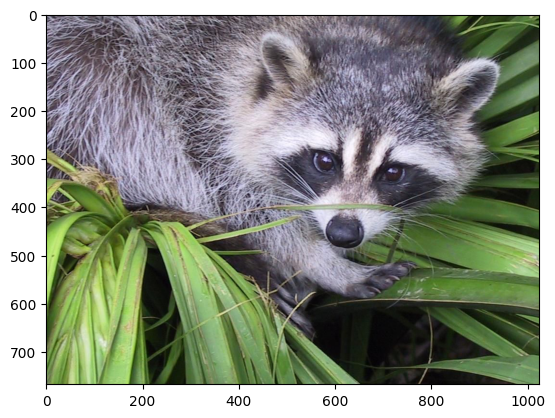

In [2]:
im_data = scipy.misc.face()
im = Image2DModel.parse(im_data, dims=["y", "x", "c"])
plt.imshow(im.transpose("y", "x", "c").data)

Let's generate and parse the labels (for this we'll use the {meth}`skimage.segmentation.slic` algorithm).

INFO     Transposing `data` of type: <class 'dask.array.core.Array'> to ('y', 'x').                                


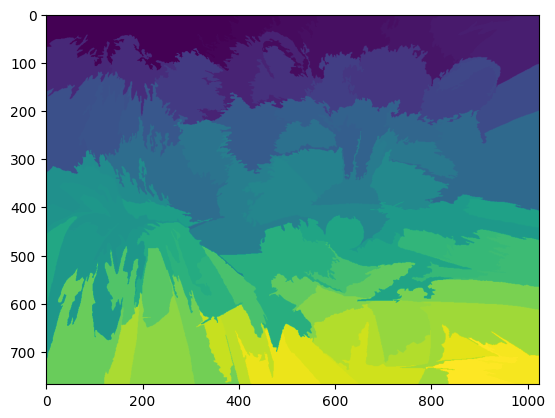

In [3]:
labels_data = slic(im_data, n_segments=100, compactness=10, sigma=1)
labels = Labels2DModel.parse(labels_data, dims=["y", "x"])
plt.imshow(labels)

And circles

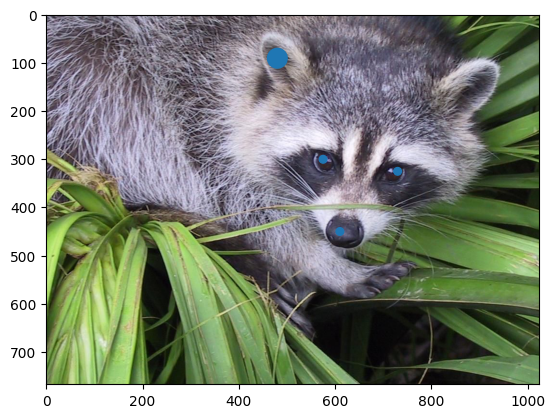

In [4]:
coords = np.array([[610, 450], [730, 325], [575, 300], [480, 90]])
circles = ShapesModel.parse(coords, geometry=0, radius=np.array([30, 30, 30, 200]))
plt.imshow(im.transpose("y", "x", "c").data)
plt.scatter(circles.geometry.x, circles.geometry.y, s=circles.radius)

We can finally create the {class}`spatialdata.SpatialData` object and plot it.

SpatialData object with:
├── Images
│     └── 'raccoon': SpatialImage[cyx] (3, 768, 1024)
├── Labels
│     └── 'segmentation': SpatialImage[yx] (768, 1024)
└── Shapes
      └── 'circles': GeoDataFrame shape: (4, 2) (2D shapes)
with coordinate systems:
▸ 'global', with elements:
        raccoon (Images), segmentation (Labels), circles (Shapes)


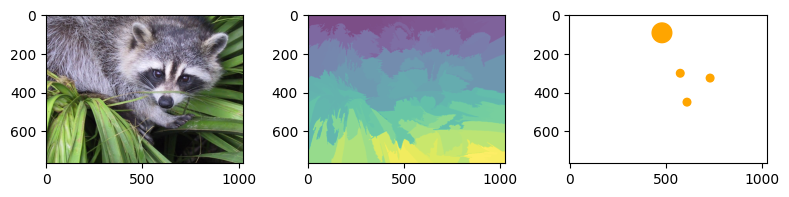

In [5]:
sdata0 = SpatialData(images={"raccoon": im}, labels={"segmentation": labels}, shapes={"circles": circles})
print(sdata0)

plot_raccoon(sdata0, split=True)

## Transformations and coordinate systems

From the `repr` printed above, you can already see that the `SpatialData` object has a `coordinate_system` attribute, which is a {class}`spatialdata.coordinate_systems.CoordinateSystem` object.

The `coordinate_systems` defines the coordinate system of the data, and they store the transformations needed for the element to be converted to the coordinate system.
At the moment, there is coordinate system available: `global`. In this coordinate system, there are 3 elements:

- `raccoon`: the raccoon image.
- `segmentation`: the segmentation mask.
- `circles`: the circles.

This is the default coordinate system that is added at the parsing stage, if no other transformation is specified. We can also expect that they are all {class}`spatialdata.transformations.Identity` transformations.
Let's print the availale coordinate systems in the SpatialData object and the transformations.

In [6]:
print(sdata0.coordinate_systems)
print(
    get_transformation(sdata0.images["raccoon"]),
    get_transformation(sdata0.labels["segmentation"]),
    get_transformation(sdata0.shapes["circles"]),
)

['global']
Identity  Identity  Identity 


Now that we understood what is a transformation and what is a coordinate system, let's see how we can use them.

Let's start by creating a new transformation, a simple {class}`spatialdata.transformations.Scale`. This transformation will scale the `"x"` axis by a factor of 2.

In [7]:
scale = Scale([2.0], axes=("x",))
set_transformation(sdata0.images["raccoon"], scale, to_coordinate_system="global")

Let's now plot the transformed element. We will do it step by step with `matplotlib` to understand what is happening. Later on, we will use the `plot_raccoon` helper function we defined above, with the argument `transform=True`, which is doing the same thing.

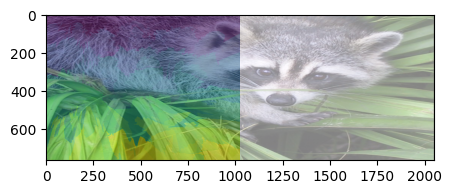

In [8]:
image_transform = get_transformation(sdata0.images["raccoon"])  # get the transformation for the image
im = image_transform.transform(sdata0.images["raccoon"])  # transform the image
labels_transform = get_transformation(sdata0.labels["segmentation"])  # get the transformation for the labels
lab = labels_transform.transform(sdata0.labels["segmentation"])  # transform the labels

_, ax = plt.subplots(1, 1, figsize=(5, 3))

ax.imshow(lab.data)
ax.imshow(im.transpose("y", "x", "c").data, alpha=0.5)
plt.show()

Notice that we passed the elements as is. The transformation API is able to understand what is the type of element as well as how the transformation should be applied to it.

The helper function we defined above does exactly the same thing, but it is a bit more convenient to use.

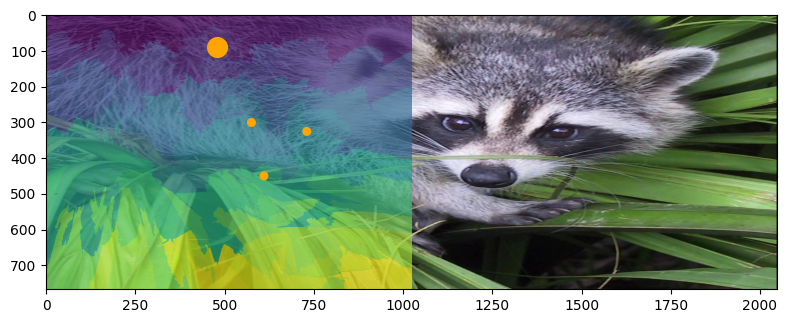

In [9]:
plot_raccoon(sdata0, transform=True)

## Various transformations

Let's now explore various transformations available in `SpatialData`.

### MapAxis

The {class}`spatialdata.transformations.MapAxis` transformation can be used to permute the axis of the elements.

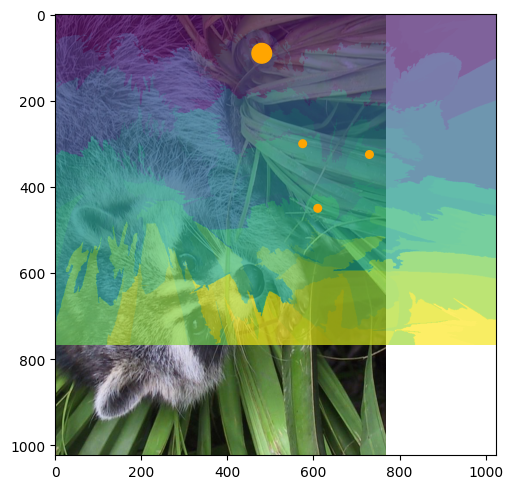

In [10]:
map_axis = MapAxis({"x": "y", "y": "x"})
set_transformation(sdata0.images["raccoon"], map_axis, to_coordinate_system="global")
plot_raccoon(sdata0, transform=True)

### Rotation

The {class}`spatialdata.transformations.Affine` transformation can be used to apply an affine transformation to the elements. Let's start with a rotation.

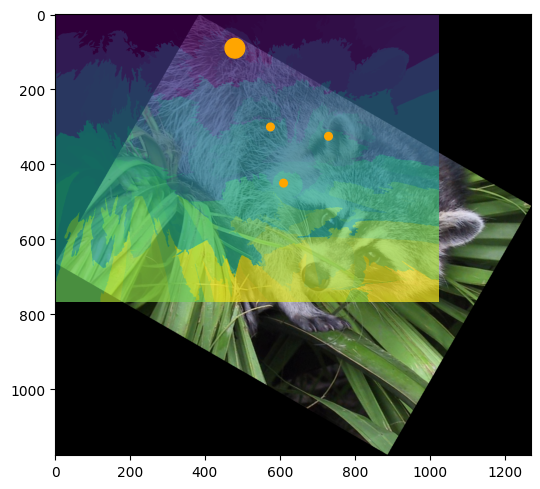

In [11]:
theta = math.pi / 6
rotation = Affine(
    [
        [math.cos(theta), -math.sin(theta), 0],
        [math.sin(theta), math.cos(theta), 0],
        [0, 0, 1],
    ],
    input_axes=("x", "y"),
    output_axes=("x", "y"),
)
set_transformation(sdata0.images["raccoon"], rotation, to_coordinate_system="global")
plot_raccoon(sdata0, transform=True)

### Translation

The {class}`spatialdata.transformations.Translation` transformation can be used to apply a translation to the element.

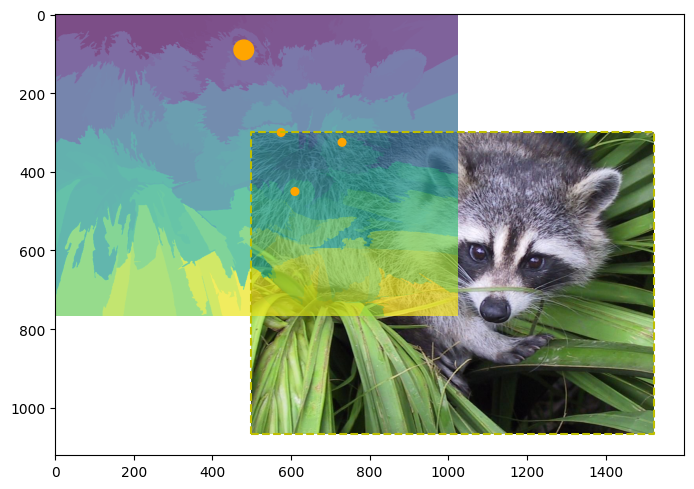

In [12]:
translation = Translation([500, 300], axes=("x", "y"))
set_transformation(sdata0.images["raccoon"], translation, to_coordinate_system="global")
plot_raccoon(sdata0, transform=True)

### Affine transformation and composition

The {class}`spatialdata.transformations.Sequence` transformation class can be used to compose transformations. This class allows to compose multiple transformations and it can be used even when the axes do not strictly match.

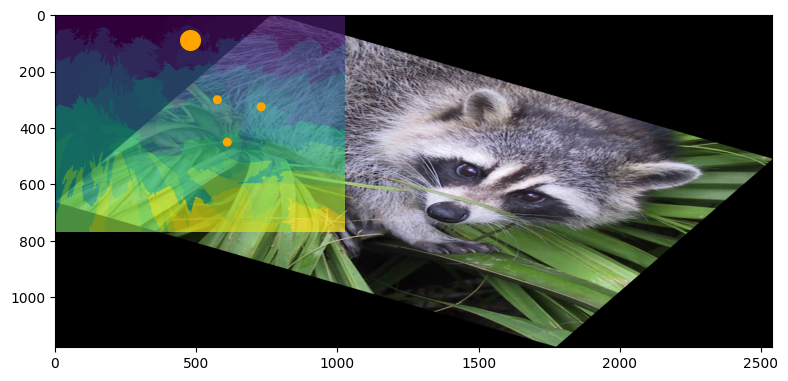

In [13]:
sequence = Sequence([rotation, scale])
set_transformation(sdata0.images["raccoon"], sequence, to_coordinate_system="global")
plot_raccoon(sdata0, transform=True)

We can also visualize the resulting affine matrix of the transformation.

In [14]:
print(sequence.to_affine_matrix(input_axes=("x", "y"), output_axes=("x", "y")))

[[ 1.73205081 -1.          0.        ]
 [ 0.5         0.8660254   0.        ]
 [ 0.          0.          1.        ]]


As shown before, transformations can be applied to various elements without the constraint that the axes must match.
For example, a {class}`spatialdata.transformations.Scale` transformation over axis `"x"` can be applied both to circles and to images.

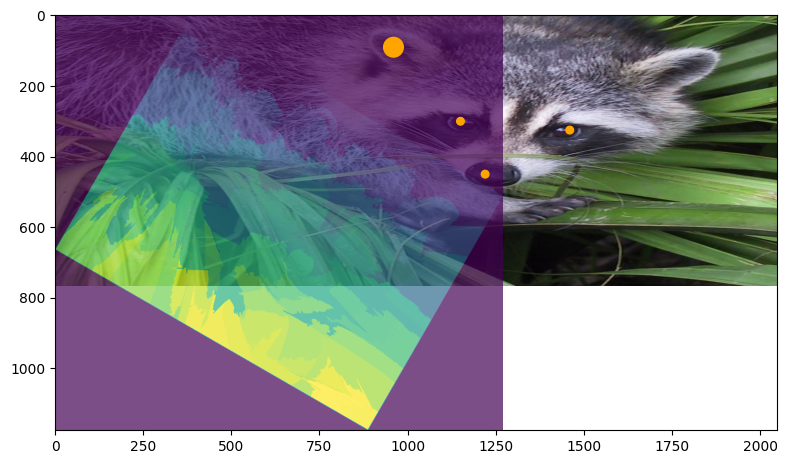

In [18]:
set_transformation(sdata0.images["raccoon"], scale, to_coordinate_system="global")
set_transformation(sdata0.shapes["circles"], scale, to_coordinate_system="global")
set_transformation(sdata0.labels["segmentation"], rotation, to_coordinate_system="global")
plot_raccoon(sdata0, transform=True)

### Inverse transformations

Most of the transformations also have an `inverse` method that returns the inverse transformation. If composed, they effectively cancel each other out.

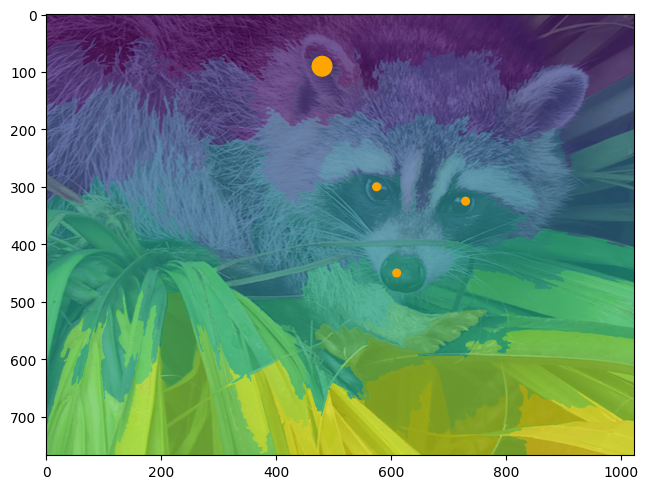

In [ ]:
sequence = Sequence([rotation, rotation.inverse(), scale, scale.inverse()])
set_transformation(sdata0.images["raccoon"], sequence, to_coordinate_system="global")
plot_raccoon(sdata0, transform=True)

### Transformations and Axes

A transformation object can also retried the affine matrix with the {meth}`spatialdata.transformations.Transformation.to_affine_matrix` method. 
This method takes as input the axes of the input element and the axes of the output element. The affine matrix is built consistently according to the input and output axes.

Let's see an example.

notice that z doesn't appear in the output axes since it was not in the input axes, but c is passed through since it was in the input axes
you can see it below (this is the same matrix that gets printed as output
Most of the transformations also have an `inverse` method that returns the inverse transformation. If composed, they effectively cancel each other out.

In [19]:
print(translation.to_affine_matrix(input_axes=("x", "y"), output_axes=("x", "y")))
print(translation.to_affine_matrix(input_axes=("x", "y", "z"), output_axes=("x", "y", "z")))

[[  1.   0. 500.]
 [  0.   1. 300.]
 [  0.   0.   1.]]
[[  1.   0.   0. 500.]
 [  0.   1.   0. 300.]
 [  0.   0.   1.   0.]
 [  0.   0.   0.   1.]]


The affine matrix is built consistently according to the input and output axes.

The axes at input and output can also have mismatch and the affine matrix will be built accordingly.

In [21]:
print(translation.to_affine_matrix(input_axes=("x", "y", "c"), output_axes=("c", "z", "y", "x")))

[[  0.   0.   1.   0.]
 [  0.   0.   0.   0.]
 [  0.   1.   0. 300.]
 [  1.   0.   0. 500.]
 [  0.   0.   0.   1.]]


notice that z doesn't appear in the output axes since it was not in the input axes, but c is passed through since it was in the input axes
This is the same matrix that gets printed as output above.

|   | x | y | c |   |
|----|---|---|---|---|
| c | 0 | 0 | 1 | 0 |
| z | 0 | 0 | 0 | 0 | |
| y | 0 | 1 | 0 | 300 |
| x | 1 | 0 | 0 | 500 |
|   | 0 | 0 | 0 | 1 |

In [20]:
print(translation.to_affine_matrix(input_axes=("x", "y"), output_axes=("x", "y")))
print(translation.to_affine_matrix(input_axes=("x", "y", "z"), output_axes=("x", "y", "z")))
with pytest.raises(ValueError, match="Input axes must be a subset of output axes."):
    print(translation.to_affine_matrix(input_axes=("c", "z", "y", "x"), output_axes=("x", "y")))
# notice that z doesn't appear in the output axes since it was not in the input axes, but c is passed through since it was in the input axes
# you can see it below (this is the same matrix that gets printed as output
#     x   y   c
# c   0   0   1   0
# z   0   0   0   0
# y   0   1   0 100
# x   1   0   0 100
#     0   0   0   1
print(translation.to_affine_matrix(input_axes=("x", "y", "c"), output_axes=("c", "z", "y", "x")))

[[  1.   0. 100.]
 [  0.   1. 200.]
 [  0.   0.   1.]]
[[  1.   0.   0. 100.]
 [  0.   1.   0. 200.]
 [  0.   0.   1. 300.]
 [  0.   0.   0.   1.]]
[[  0.   0.   1.   0.]
 [  0.   0.   0.   0.]
 [  0.   1.   0. 200.]
 [  1.   0.   0. 100.]
 [  0.   0.   0.   1.]]


In [21]:
set_transformation(im, rotation)
print(get_transformation_between_coordinate_systems(sdata0, im, "global"))
print(get_transformation_between_coordinate_systems(sdata0, "global", im))

Sequence 
    Affine (x, y -> x, y)
        [ 0.8660254 -0.5        0.       ]
        [0.5       0.8660254 0.       ]
        [0. 0. 1.]
Sequence 
    Affine (x, y -> x, y)
        [0.8660254 0.5       0.       ]
        [-0.5        0.8660254  0.       ]
        [0. 0. 1.]


In [22]:
print(get_transformation_between_coordinate_systems(sdata0, im, "my_other_space0"))

Sequence 
    Identity 


In [23]:
print(get_transformation_between_coordinate_systems(sdata0, "global", "my_other_space0"))

Sequence 
    Affine (x, y -> x, y)
        [0.8660254 0.5       0.       ]
        [-0.5        0.8660254  0.       ]
        [0. 0. 1.]
    Identity 


In [24]:
print(get_transformation_between_coordinate_systems(sdata0, im, la))

Sequence 
    Affine (x, y -> x, y)
        [ 0.8660254 -0.5        0.       ]
        [0.5       0.8660254 0.       ]
        [0. 0. 1.]
    Identity 


In [25]:
print(get_transformation(im, get_all=True))
# remove_transformation_in_memory() is a static function, whle remove_transformation() can only operate on
# SpatialData objects, so it needs to check if the spatiadata object is backed by a zarr file
print(remove_transformation(im, "my_other_space0"))
print(get_transformation(im, get_all=True))

{'global': Affine (x, y -> x, y)
    [ 0.8660254 -0.5        0.       ]
    [0.5       0.8660254 0.       ]
    [0. 0. 1.], 'my_other_space0': Identity }
None
{'global': Affine (x, y -> x, y)
    [ 0.8660254 -0.5        0.       ]
    [0.5       0.8660254 0.       ]
    [0. 0. 1.]}


In [26]:
sdata1 = SpatialData(images={"im0": im, "im1": im, "im2": im})
with pytest.raises(ValueError, match="Element found multiple times in the SpatialData object"):
    set_transformation(im, Identity(), write_to_sdata=sdata1)

In [27]:
print(get_transformation(im, get_all=True))
remove_transformation(im, "global")
print(get_transformation(im, get_all=True))

{'global': Affine (x, y -> x, y)
    [ 0.8660254 -0.5        0.       ]
    [0.5       0.8660254 0.       ]
    [0. 0. 1.]}
{}


In [28]:
tmpdir = tempfile.TemporaryDirectory()

In [29]:
zarr_path = os.path.join(tmpdir.name, "sdata.zarr")
# writing an object re-reads the file immediately...
sdata1.write(zarr_path)
print(sdata1)
# ...so now the objects we read are distinct
im0 = sdata1.images["im0"]
im1 = sdata1.images["im1"]
im2 = sdata1.images["im2"]
assert len({id(im0), id(im1), id(im2)}) == 3

SpatialData object with:
└── Images
      ├── 'im0': SpatialImage[cyx] (3, 768, 1024)
      ├── 'im1': SpatialImage[cyx] (3, 768, 1024)
      └── 'im2': SpatialImage[cyx] (3, 768, 1024)
with coordinate systems:



In [30]:
scale = Scale([2.0], axes=("x",))
set_transformation(im0, scale, "space0")
set_transformation(im1, scale.inverse(), "space0")
set_transformation(im1, scale, "space1")
set_transformation(im2, scale.inverse(), "space1")
set_transformation(im2, scale, "space2")

print(sdata1.coordinate_systems)
print(
    get_transformation_between_coordinate_systems(
        sdata=sdata1, source_coordinate_system="space0", target_coordinate_system="space2"
    ).to_affine_matrix(input_axes=("x", "y"), output_axes=("x", "y"))
)
print(
    get_transformation_between_coordinate_systems(
        sdata=sdata1, source_coordinate_system="space2", target_coordinate_system="space0"
    ).to_affine_matrix(input_axes=("x"), output_axes=("x"))
)

['space1', 'space0', 'space2']
[[16.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  0.  1.]]
[[0.0625 0.    ]
 [0.     1.    ]]


In [31]:
tmpdir.cleanup()

INFO     No transformations found in the element, adding a default identity transformation to the coordinate system
         global                                                                                                    
plotting... 

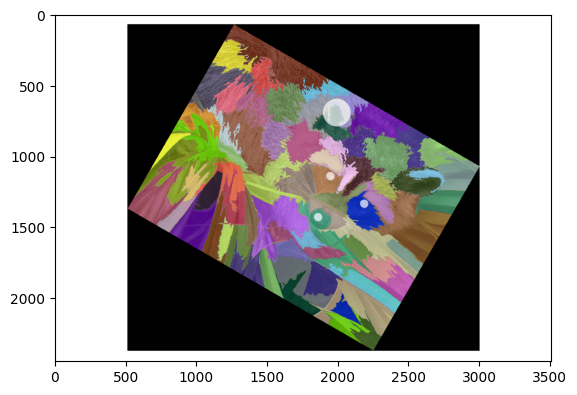

done
INFO     No transformations found in the element, adding a default identity transformation to the coordinate system
         global                                                                                                    
plotting... 

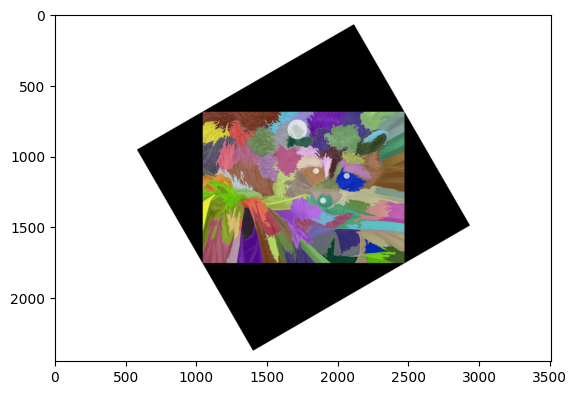

done
plotting... 

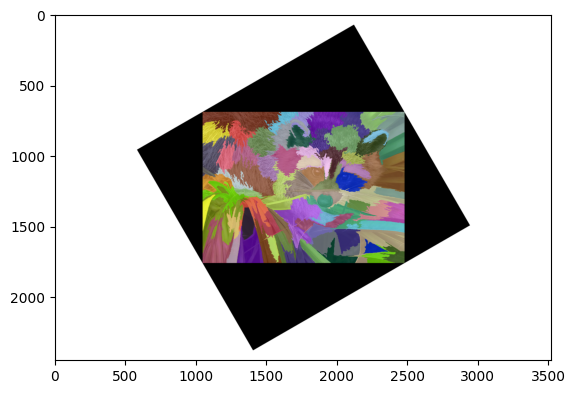

done


In [32]:
# I stop here regarding the transformations, there are some bugs (forgot to finish one part the code), gonna fix it
# see how the points are wrong
# see also how the new image is now rotated (the data is rotated itself)! the padding has been added by the method
rotated_sdata = rotation.transform(sdata0)
hacky_plot(rotated_sdata)

rotated_sdata = rotation.transform(sdata0, maintain_positioning=True)
hacky_plot(rotated_sdata)

merged_sdata = SpatialData(images={"face_rotated": rotated_sdata.images["face"]}, labels={"slic": la})
hacky_plot(merged_sdata)

In [33]:
# just a little more on io and backing
tmpdir = tempfile.TemporaryDirectory()

In [34]:
zarr_path = os.path.join(tmpdir.name, "sdata.zarr")
sdata0.write(zarr_path)

with pytest.raises(ValueError, match="Can't overwrite the original file"):
    sdata0.write(zarr_path)

another_zarr_path = os.path.join(tmpdir.name, "another_sdata.zarr")
sdata0.write(another_zarr_path)

with pytest.raises(ValueError, match="The Zarr store already exists. Use overwrite=True to overwrite the store."):
    sdata0.write(zarr_path)

sdata0.write(zarr_path, overwrite=True)

no parent found for <ome_zarr.reader.Label object at 0x7f81621589a0>: None


INFO     The Zarr file used for backing will now change from /tmp/tmp0ngjb4mf/sdata.zarr to                        
         /tmp/tmp0ngjb4mf/another_sdata.zarr                                                                       


no parent found for <ome_zarr.reader.Label object at 0x7f81a6c67640>: None


INFO     The Zarr file used for backing will now change from /tmp/tmp0ngjb4mf/another_sdata.zarr to                
         /tmp/tmp0ngjb4mf/sdata.zarr                                                                               
INFO     The Zarr file used for backing will now change from /tmp/tmp0ngjb4mf/another_sdata.zarr to                
         /tmp/tmp0ngjb4mf/sdata.zarr                                                                               


no parent found for <ome_zarr.reader.Label object at 0x7f8190c3e7d0>: None


In [35]:
sdata2 = SpatialData(images=sdata0.images)

# notice how sdata2 is not bakced, but the element is backed from zarr from the old sdata object, this is fine, let's see why
print(sdata2.is_backed())
print(sdata2.images["face"].data)

# the function called without the argument "write_to_sdata" does not overwrite the transformation of the original
# file, it jsut modifies the in-memory object of sdata2
set_transformation(sdata2.images["face"], scale)

# let's check this
print(get_transformation(sdata0.images["face"], get_all=True))
print(get_transformation(sdata2.images["face"], get_all=True))

# but
sdata0_read_again = SpatialData.read(zarr_path)
get_transformation(sdata0_read_again.images["face"], get_all=True)
# correct!

False
dask.array<from-zarr, shape=(3, 768, 1024), dtype=uint8, chunksize=(3, 768, 1024), chunktype=numpy.ndarray>
{'global': Scale (x)
    [2.]}
{'global': Scale (x)
    [2.]}


{}

In [36]:
# if we want to modify the transformation of sdata2 to disk, we have first to save it
yet_another_zarr_path = os.path.join(tmpdir.name, "yet_another_sdata.zarr")
# but now that we save it the image will point to the new zarr store; it has nothing to do with the original one anymore
sdata2.write(yet_another_zarr_path)
print(sdata2.images["face"].data)

# this modifies the transformation in-memory
set_transformation(sdata2.images["face"], scale)
# while this will change it on disk
set_transformation(sdata2.images["face"], scale, write_to_sdata=sdata2)

dask.array<from-zarr, shape=(3, 768, 1024), dtype=uint8, chunksize=(3, 768, 1024), chunktype=numpy.ndarray>


In [37]:
# finally notice that we can add new elements to a spatialdata object after it has been created
# if the object is not backed, the data will be added in-memory, otherwise it will be also immediately saved to disk
print(sdata2.is_backed())
face0 = sdata2.images["face"]
sdata2.add_image("another_face", face0)
face1 = sdata2.images["another_face"]
assert id(face0) != id(face1)
# notice how the objects are different, because when we call add_image(), the new image is immediately re-read from disk

True


In [38]:
# let's show the behaviour in-memory: let's trick the object to believe that is in-memory
sdata2.path = None
sdata2.add_image("yet_another_face", face0)
face2 = sdata2.images["yet_another_face"]
assert id(face0) == id(face2)

In [39]:
tmpdir.cleanup()